## 本示例用来演示多模态模型微调

- 运行下述命令解压到data目录
- 数据集中的样本为单轮对话形式，含有 261 条样本，每条样本都由一条系统提示、一条用户指令和一条模型回答组成，微调过程中模型不断学习样本中的回答风格，从而达到学习文旅知识的目的。数据样例如下所示：
```json
[
  {
    "conversations": [
      {
        "from": "system",
        "value": "你是一个导游，请生动有趣地回答游客提出的问题"
      },
      {
        "from": "human",
        "value": "给我讲讲这个东西<image>"
      },
      {
        "from": "gpt",
        "value": "各位游客朋友们，大家好！\n\n现在映入大家眼帘的，是一件极为珍贵的文物——**神面纹玉戚**。它可不是一般的宝贝，而是来自遥远的新石器时代的一件精美玉器哦！\n\n这件宝贝现藏于山西博物院，它的尺寸相当精致：高20.6厘米，宽13.1厘米，厚仅0.4厘米，真是薄如蝉翼，工艺精湛！\n\n1964年，它在黎城县后庄村广志山出土，仿佛穿越时空，向我们诉说着古老的故事。\n\n大家仔细看，这块玉戚采用了线刻工艺，一侧雕刻着神人的半侧面头像，头戴华美的冠饰，披拂着飘逸的长发，眼眉清晰可辨，仿佛在凝视着我们；而另一侧则是一个方形台座上置神人冠饰的形象，显得神秘而威严。\n\n要知道，玉戚在古代可是象征军事统帅权力的神器，握有它，就如同掌握了千军万马！\n\n大家不妨多停留片刻，感受一下这件文物散发出的古老而神秘的气息吧！\n\n谢谢大家的聆听，接下来我们将继续参观其他精彩展品，敬请期待！"
      }
    ],
    "images": [
      "images/instance_1579398113581395972.jpg"
    ]
  }
]
```

In [ ]:
!unzip history.zip -d data

### 加载backend/.env环境变量
- 取出region，sagemaker role


In [12]:
import sagemaker
import boto3
import dotenv
import os
dotenv.load_dotenv()

In [16]:
boto_sess = boto3.Session(
    region_name=os.environ.get('region')
)
role = os.environ.get('role')
print(f"sagemaker role:{role}")


sagemaker_session =  sagemaker.session.Session(boto_session=boto_sess) #sagemaker.session.Session()
region = sagemaker_session.boto_region_name
default_bucket = sagemaker_session.default_bucket()
print(f"sagemaker default bucket:{default_bucket}")

sagemaker role:arn:aws:iam::434444145045:role/sagemaker-modelhub


sagemaker default bucket:sagemaker-us-east-1-434444145045


### 上传至s3


In [25]:
s3_data_uri = f"s3://{default_bucket}/dataset-for-training"
training_input_path = f'{s3_data_uri}/train/multl-modal-data'
s3_upload_path = sagemaker.s3.S3Uploader.upload(local_path="./data/", desired_s3_uri=training_input_path, sagemaker_session=sagemaker_session)
print(f's3_upload_path: {s3_upload_path}/')


s3_upload_path: s3://sagemaker-us-east-1-434444145045/dataset-for-training/train/multl-modal-data/


#### 查看dataset_info.json文件的内容，使用model hub创建job时需要用到这个内容

In [26]:
import json
with open('data/dataset_info.json','r') as f:
    dataset_info = f.read()
    print(dataset_info)

{
  "train": {
    "file_name": "train.json",
    "formatting": "sharegpt",
    "columns": {
      "messages": "conversations",
      "images": "images"
    }
  }
}


## 在modelhub中创建一个训练任务
- 选择Qwen2VL-2B-Instruct模型
- 选择Qwen2VLPrompt模板
- 选择全量微调
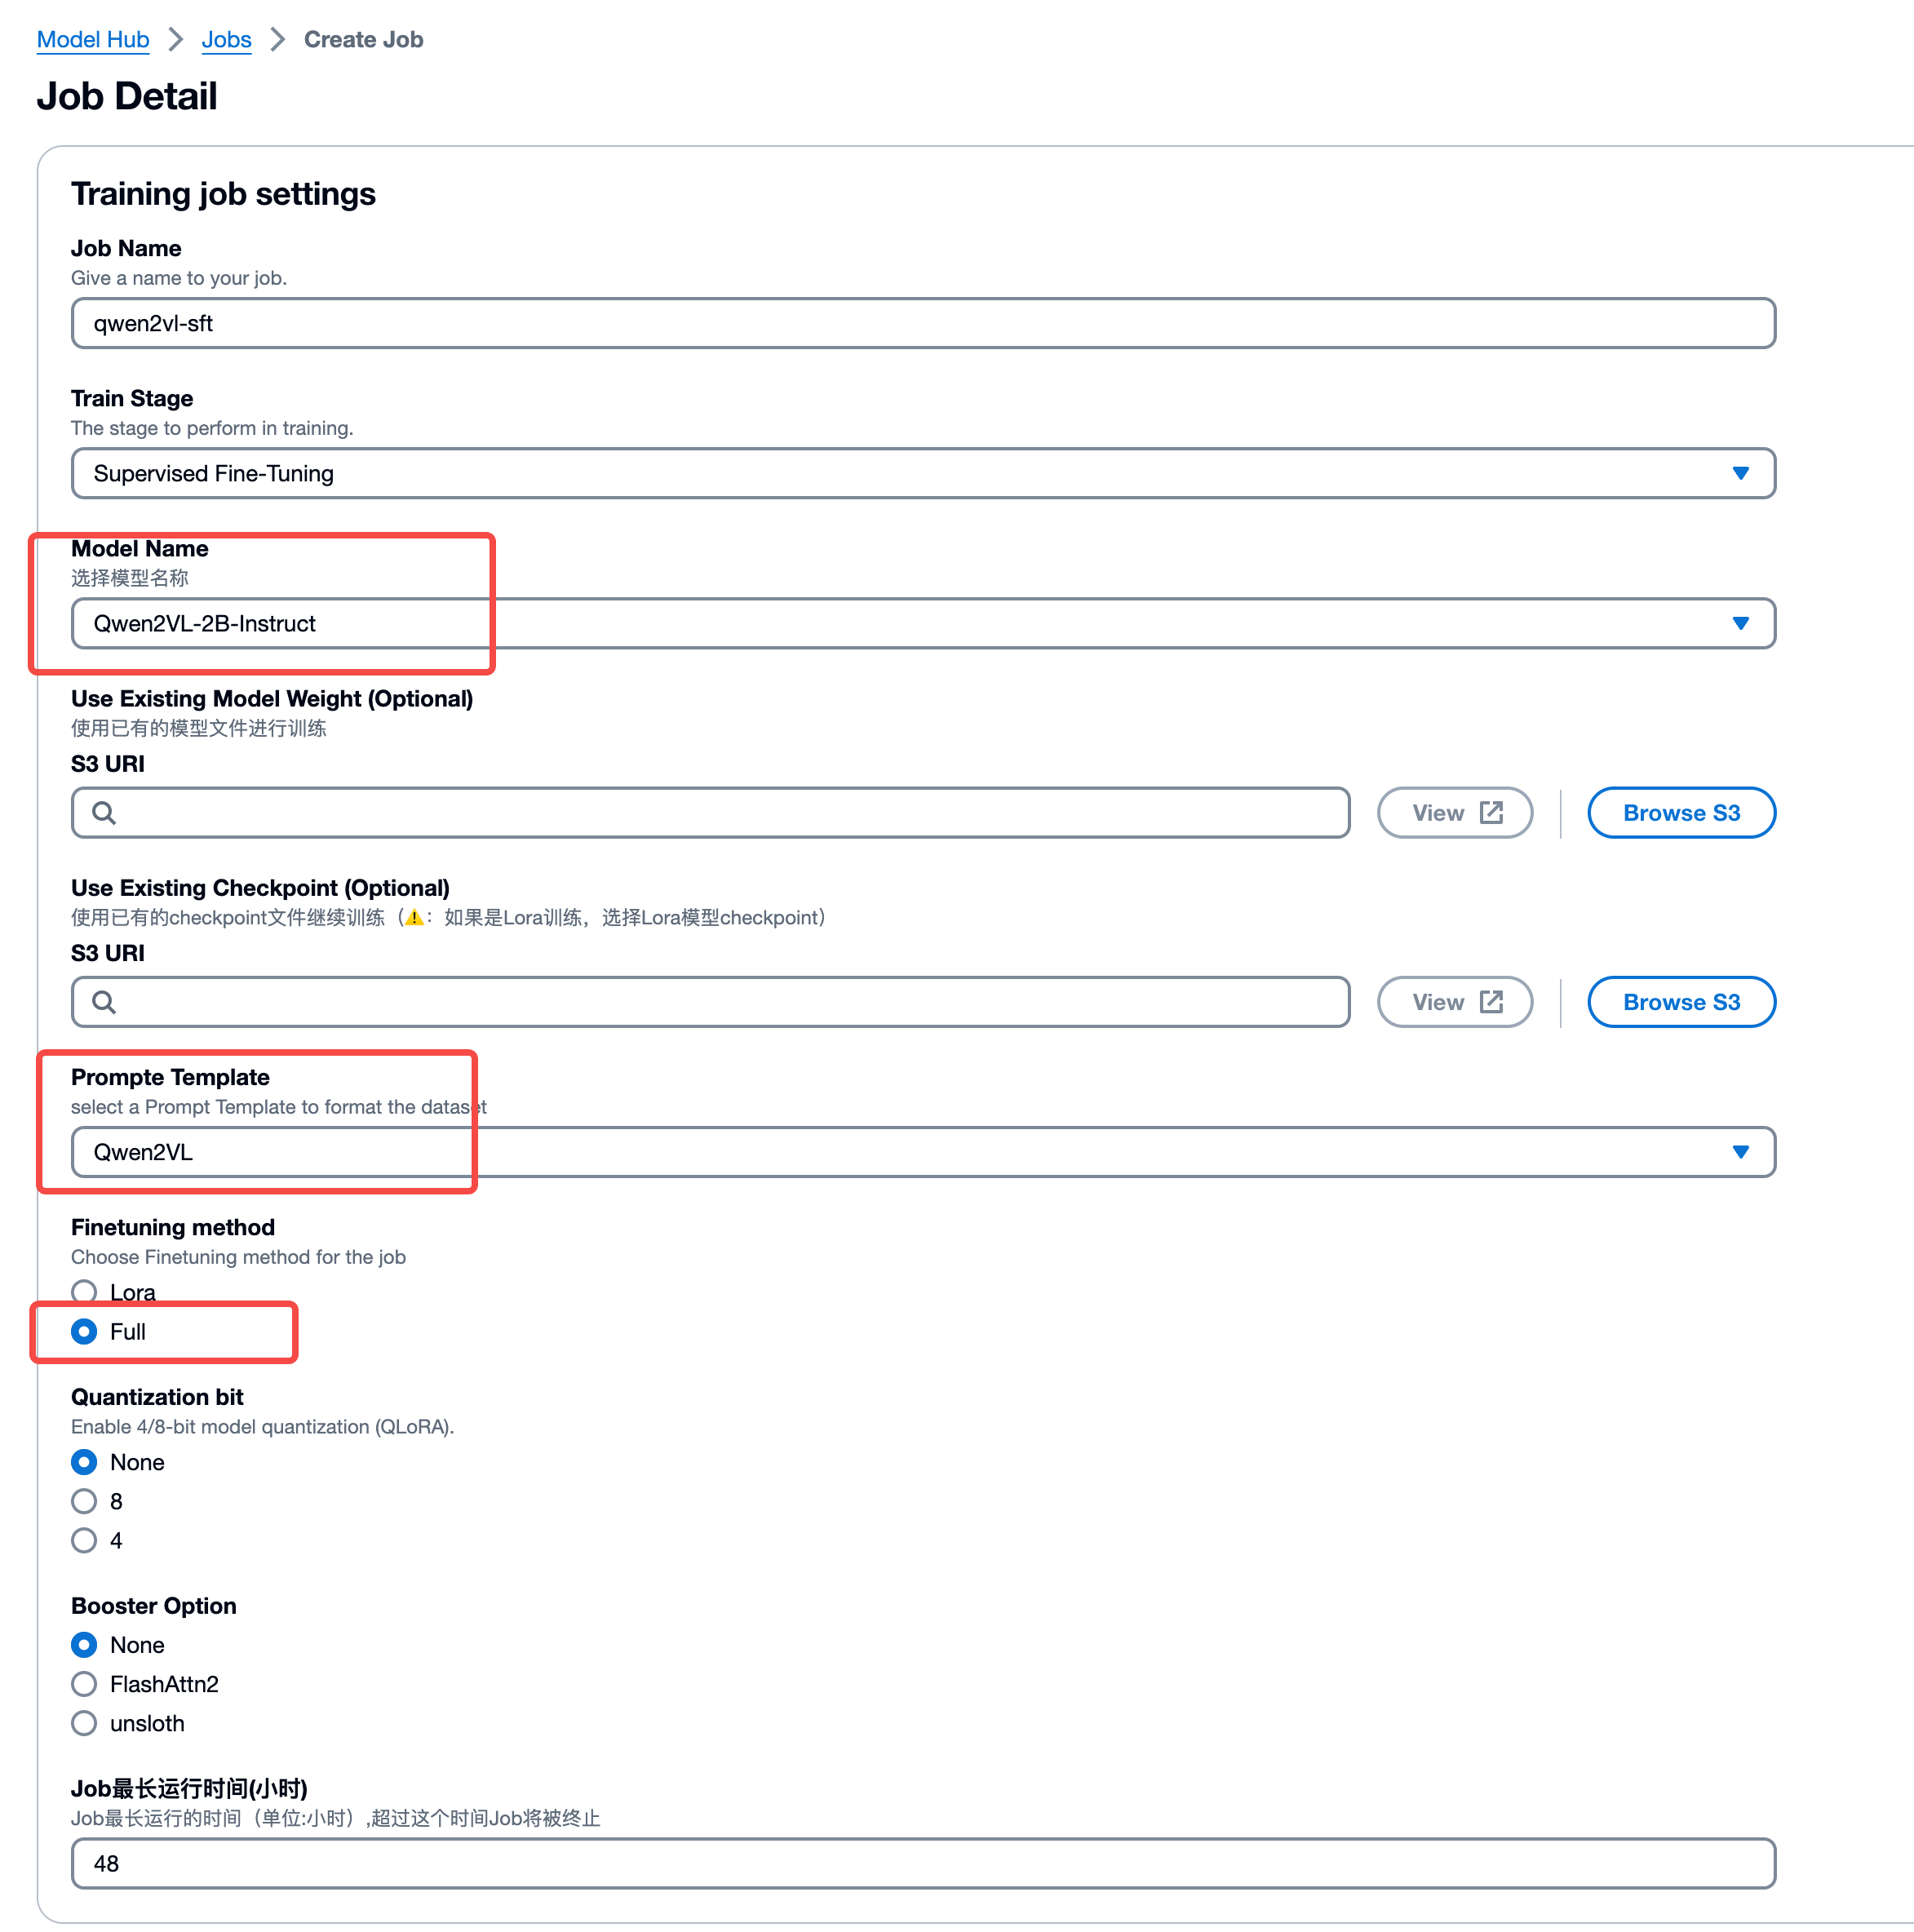


#### 在Datasets settings中添加上面步骤上传的s3_upload_path 和dataset_info
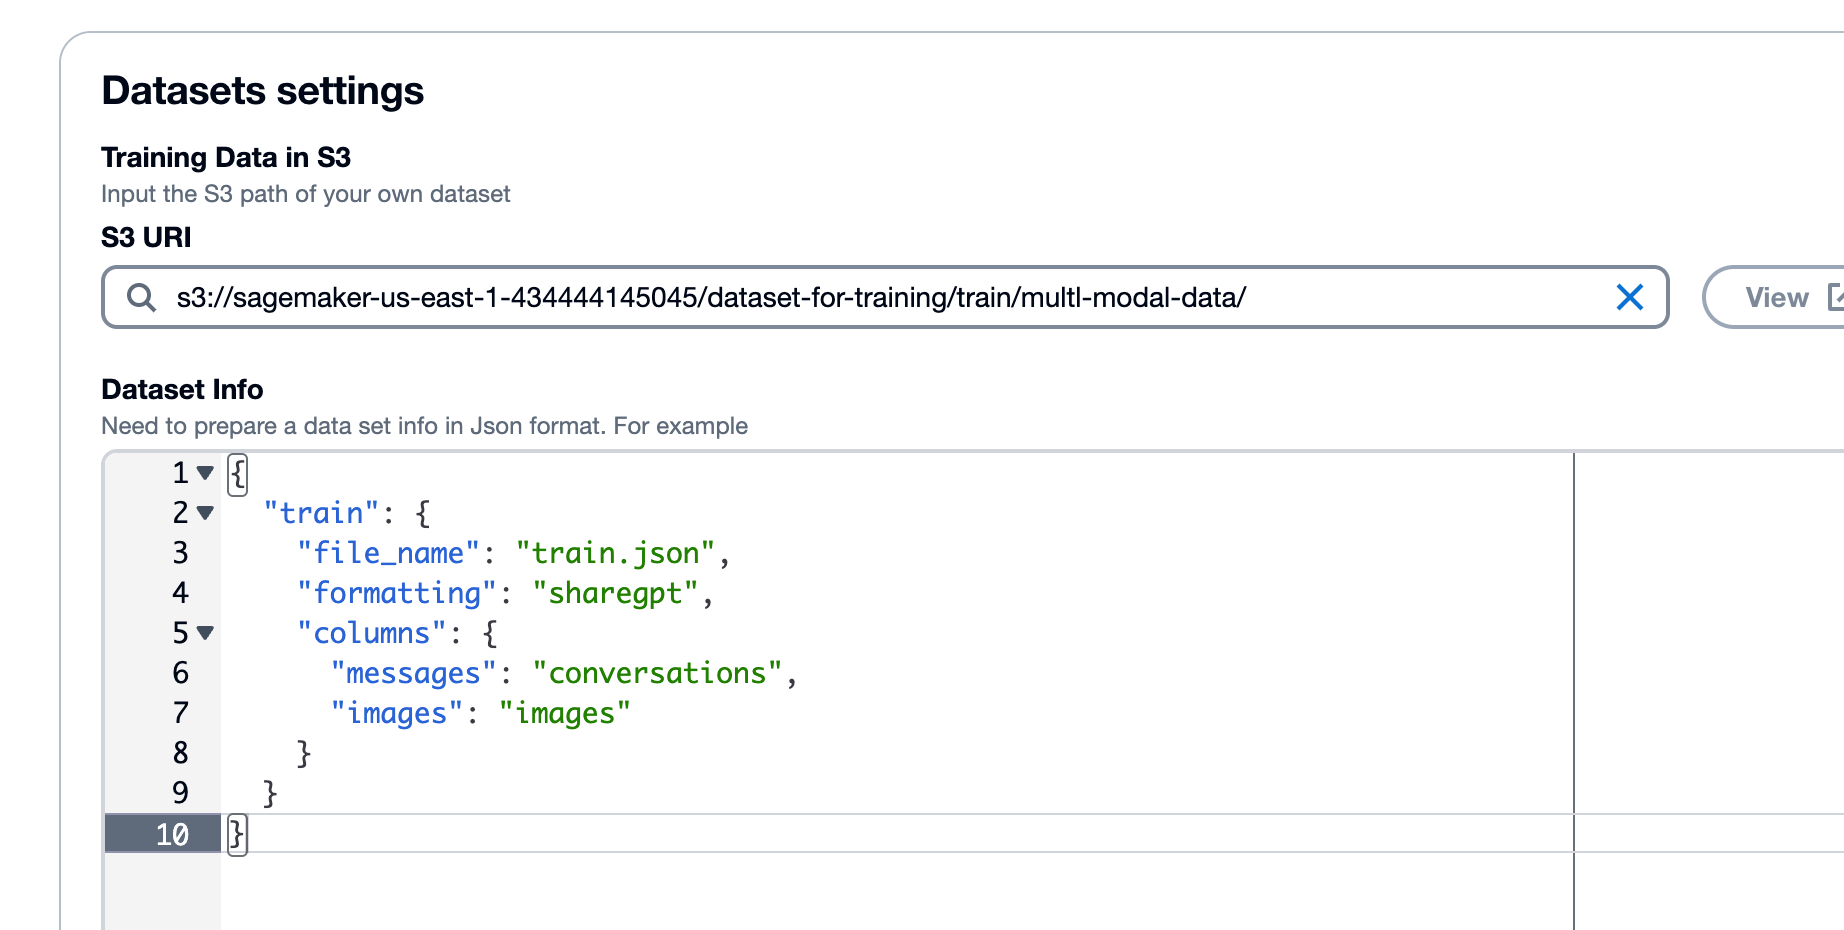

#### 选择一台g5.12xlarge作为训练机型，启动deepspeed stage 2
- g5.12xlarge有4张A10g GPU，显存24GB*4
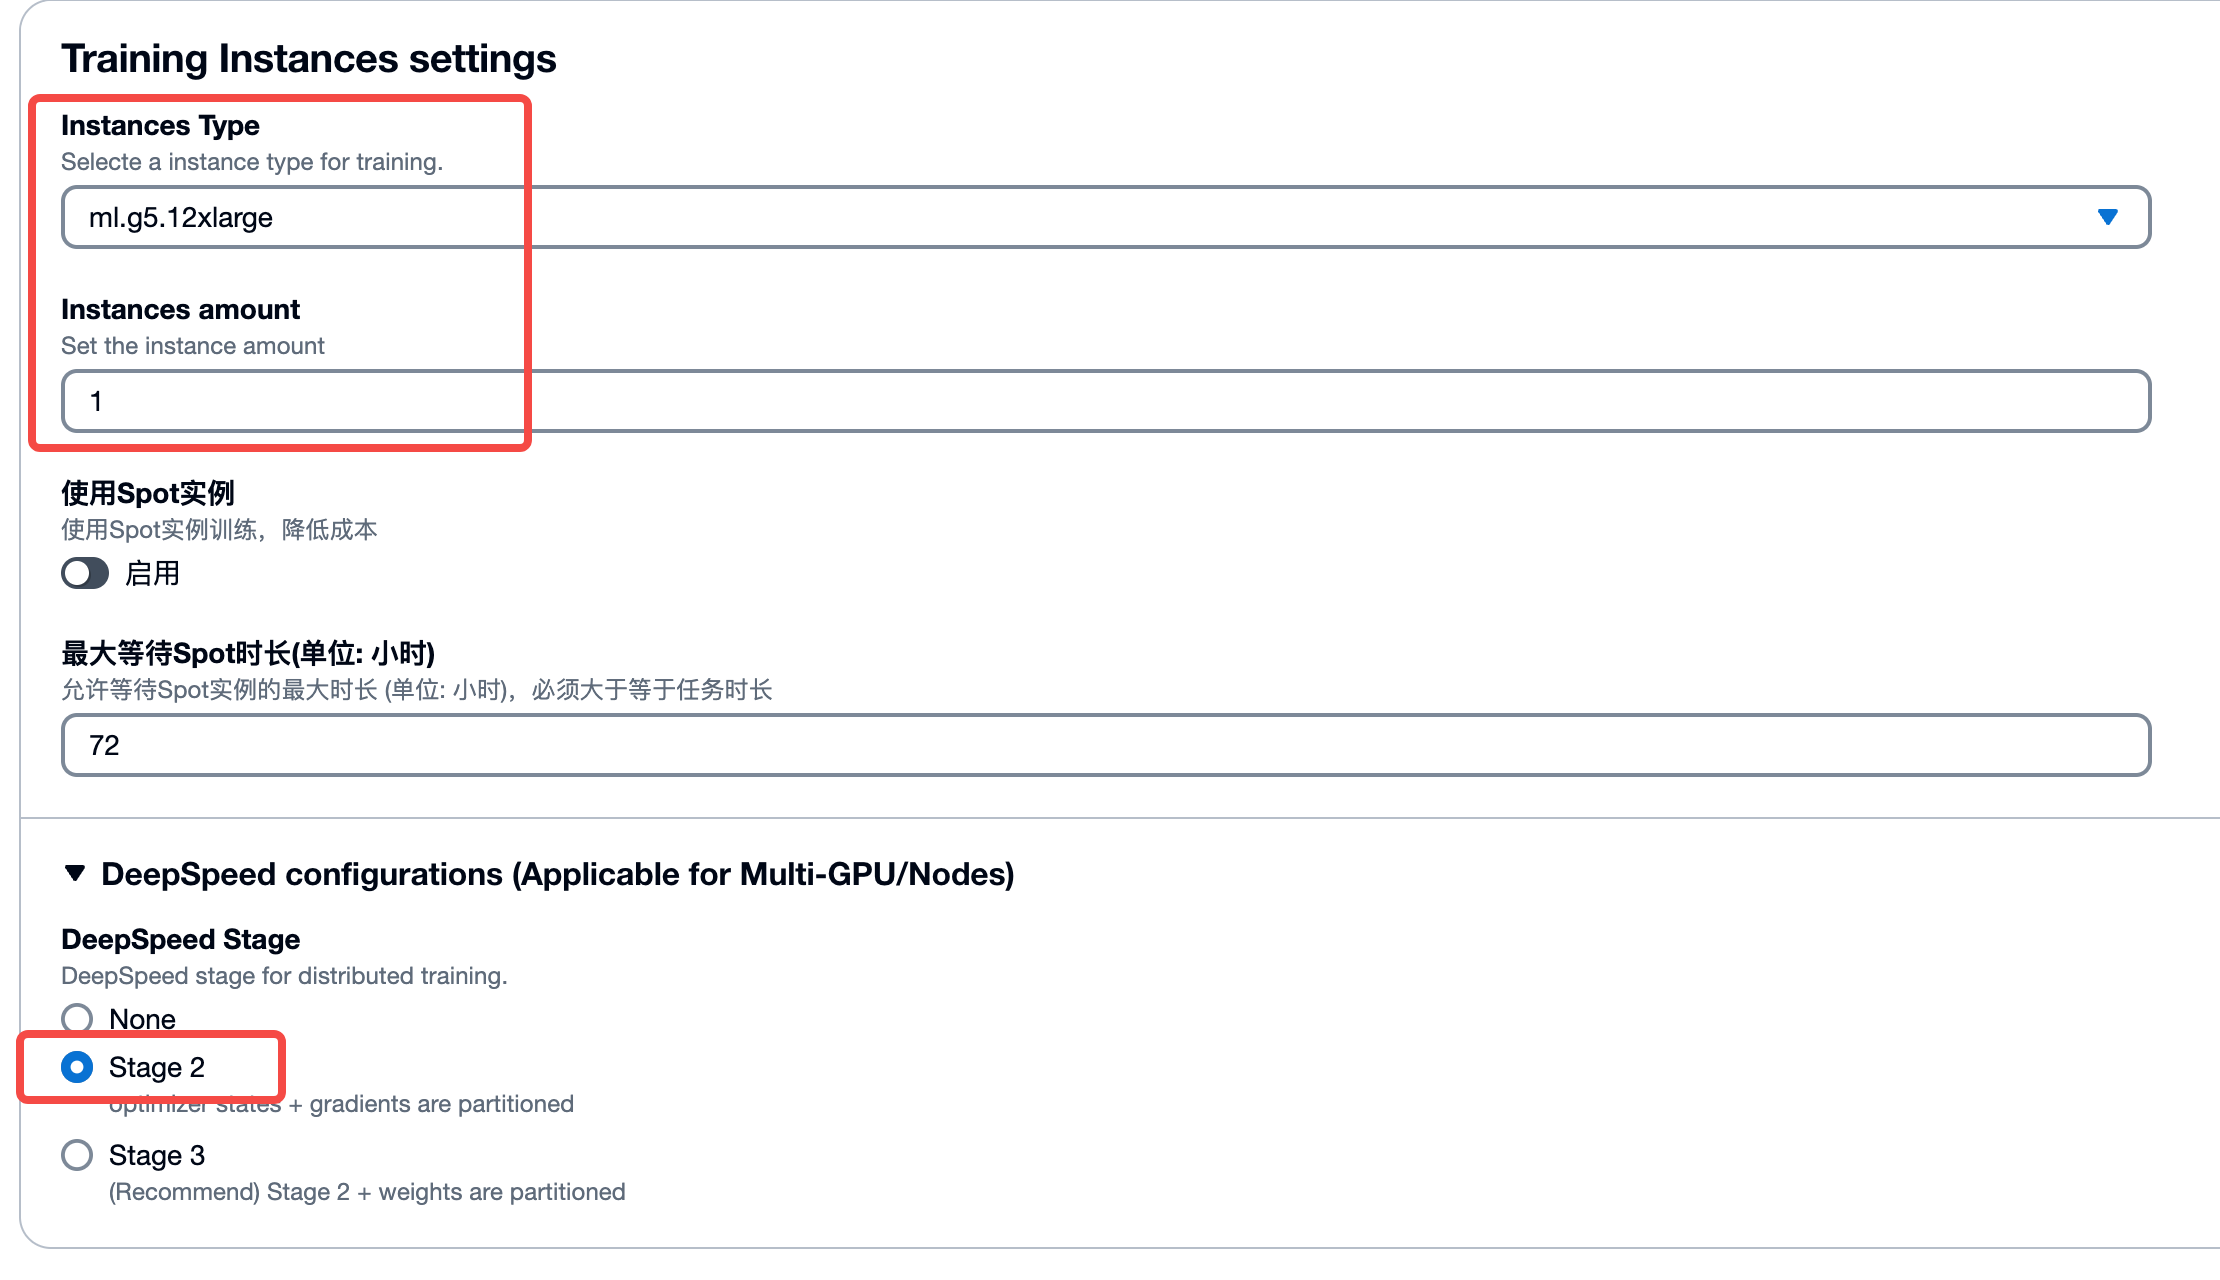

#### 训练超参如下
- Learning rate = 1e-4
- Epoch = 5
- Batch size per device = 2
- Gradient accumulation =2
= Training precision = bf16

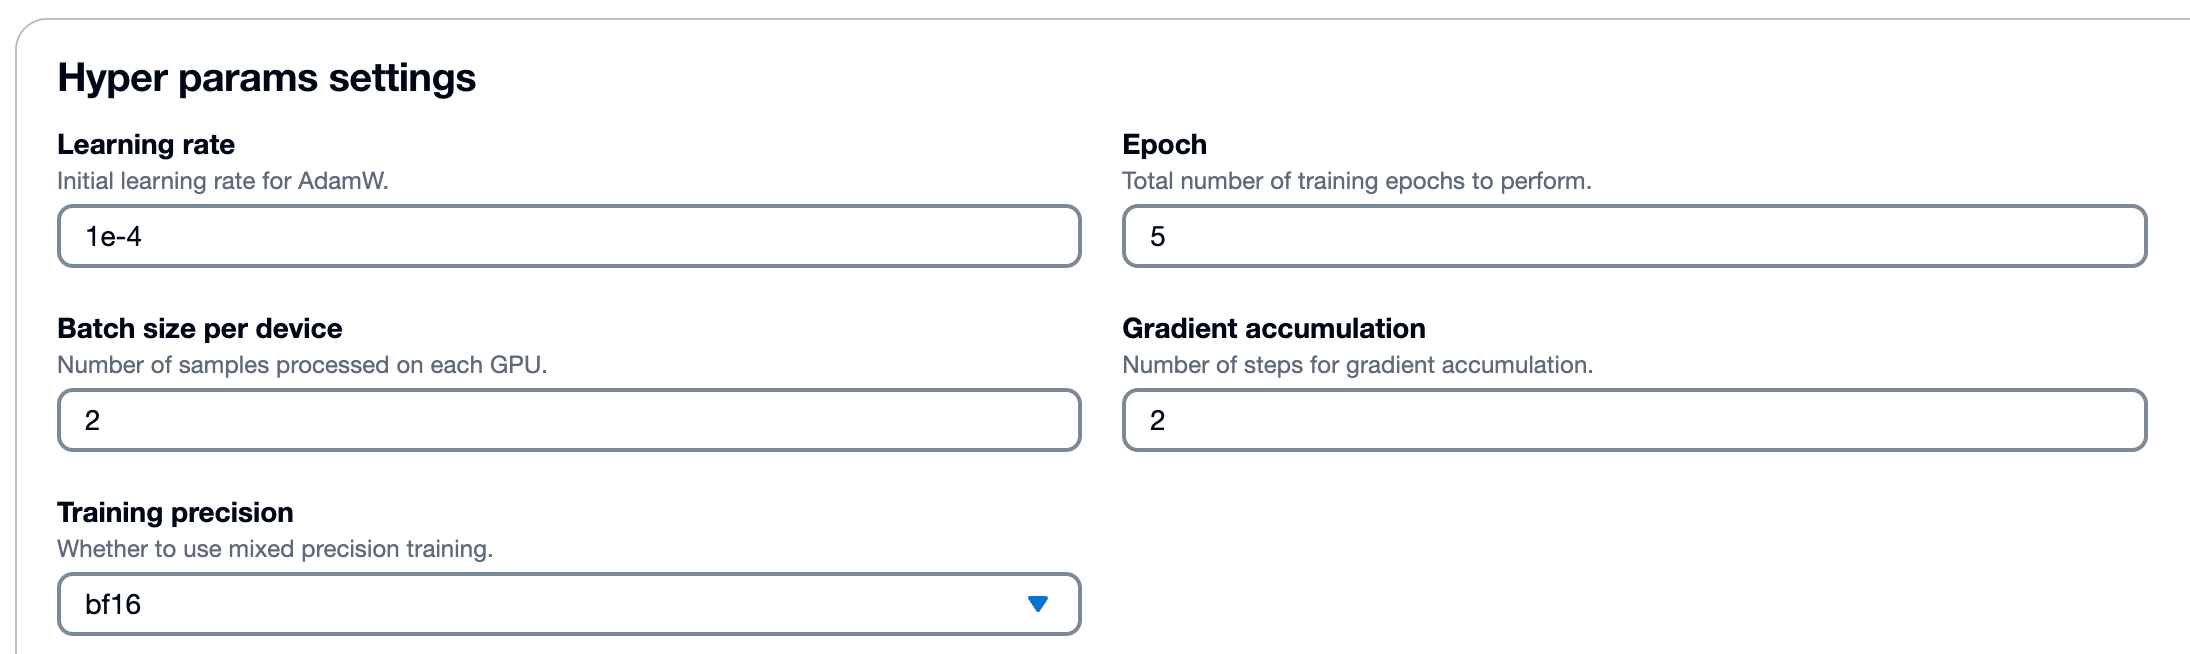

#### 等待训练完成，部署模型
- 大概20分钟后训练状态变成SUCCESS
- 在Training Jobs列表中选中任务，点击右上角“部署”按钮，默认值保持不变，点击“Confirm”
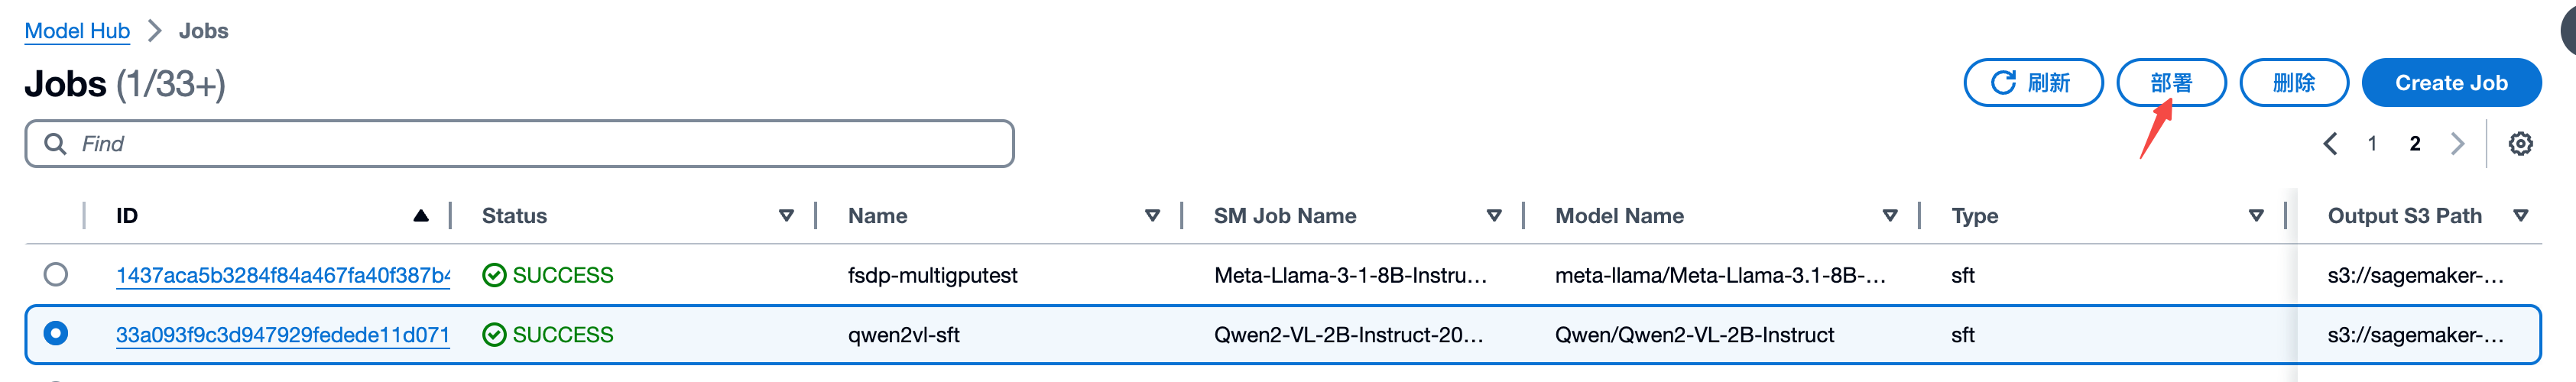

### 同时再部署一个未经过微调的模型
- 在modelhub， Endpoints菜单中，点击右上角"创建"，在模型下拉菜单中选择Qwen2-VL-2B-Instruct，其余默认值保持不变，点击"Confirm"。
- 大约等待8分钟之后，刷新列表，直到状态变成"InService"
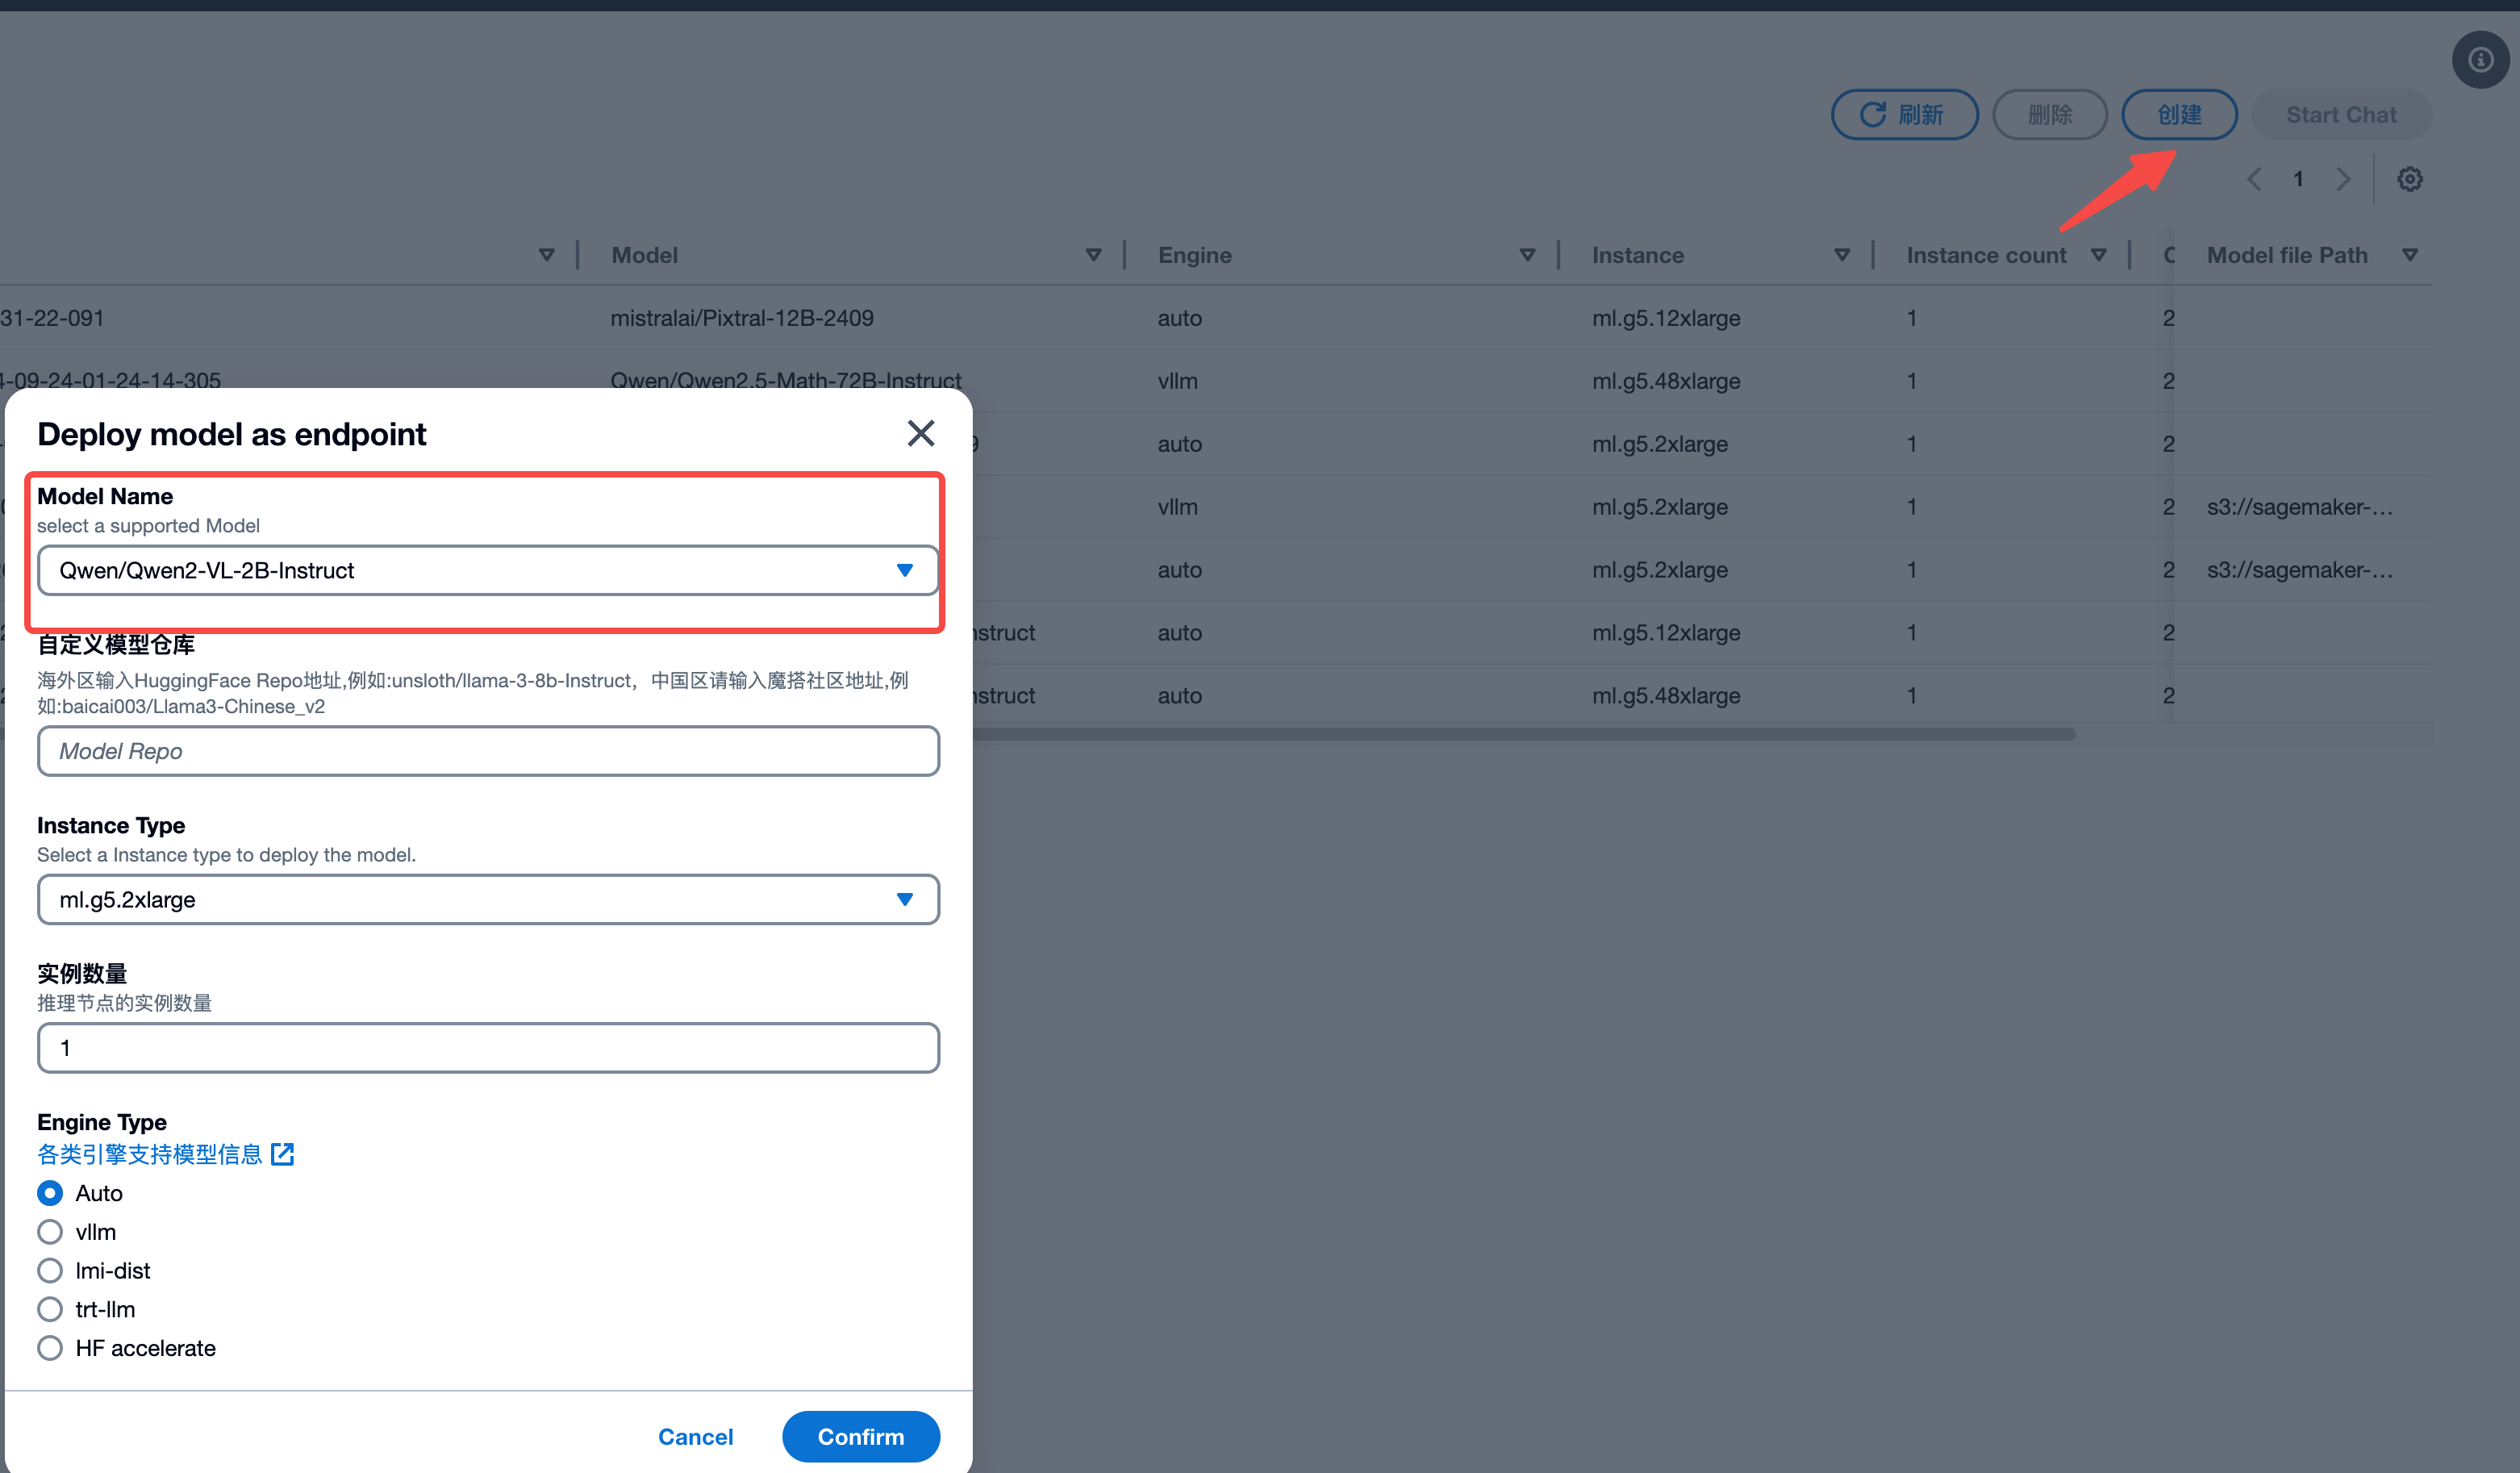

### 测试-原始模型
- 在Endpoints中选中部署成功“InService”的端点，点击右上脚“Start Chat”，进入Playground
- 首先点击下载test_images/目录下的测试图片1或图片2，并点击图片上传至对话框，接着在“更多设置”-“系统角色提示词”区域填写“你是一个导游，请生动有趣地回答游客提出的问题”。
- 在页面底部的对话框输入想要和模型对话的内容，点击提交即可发送消息。
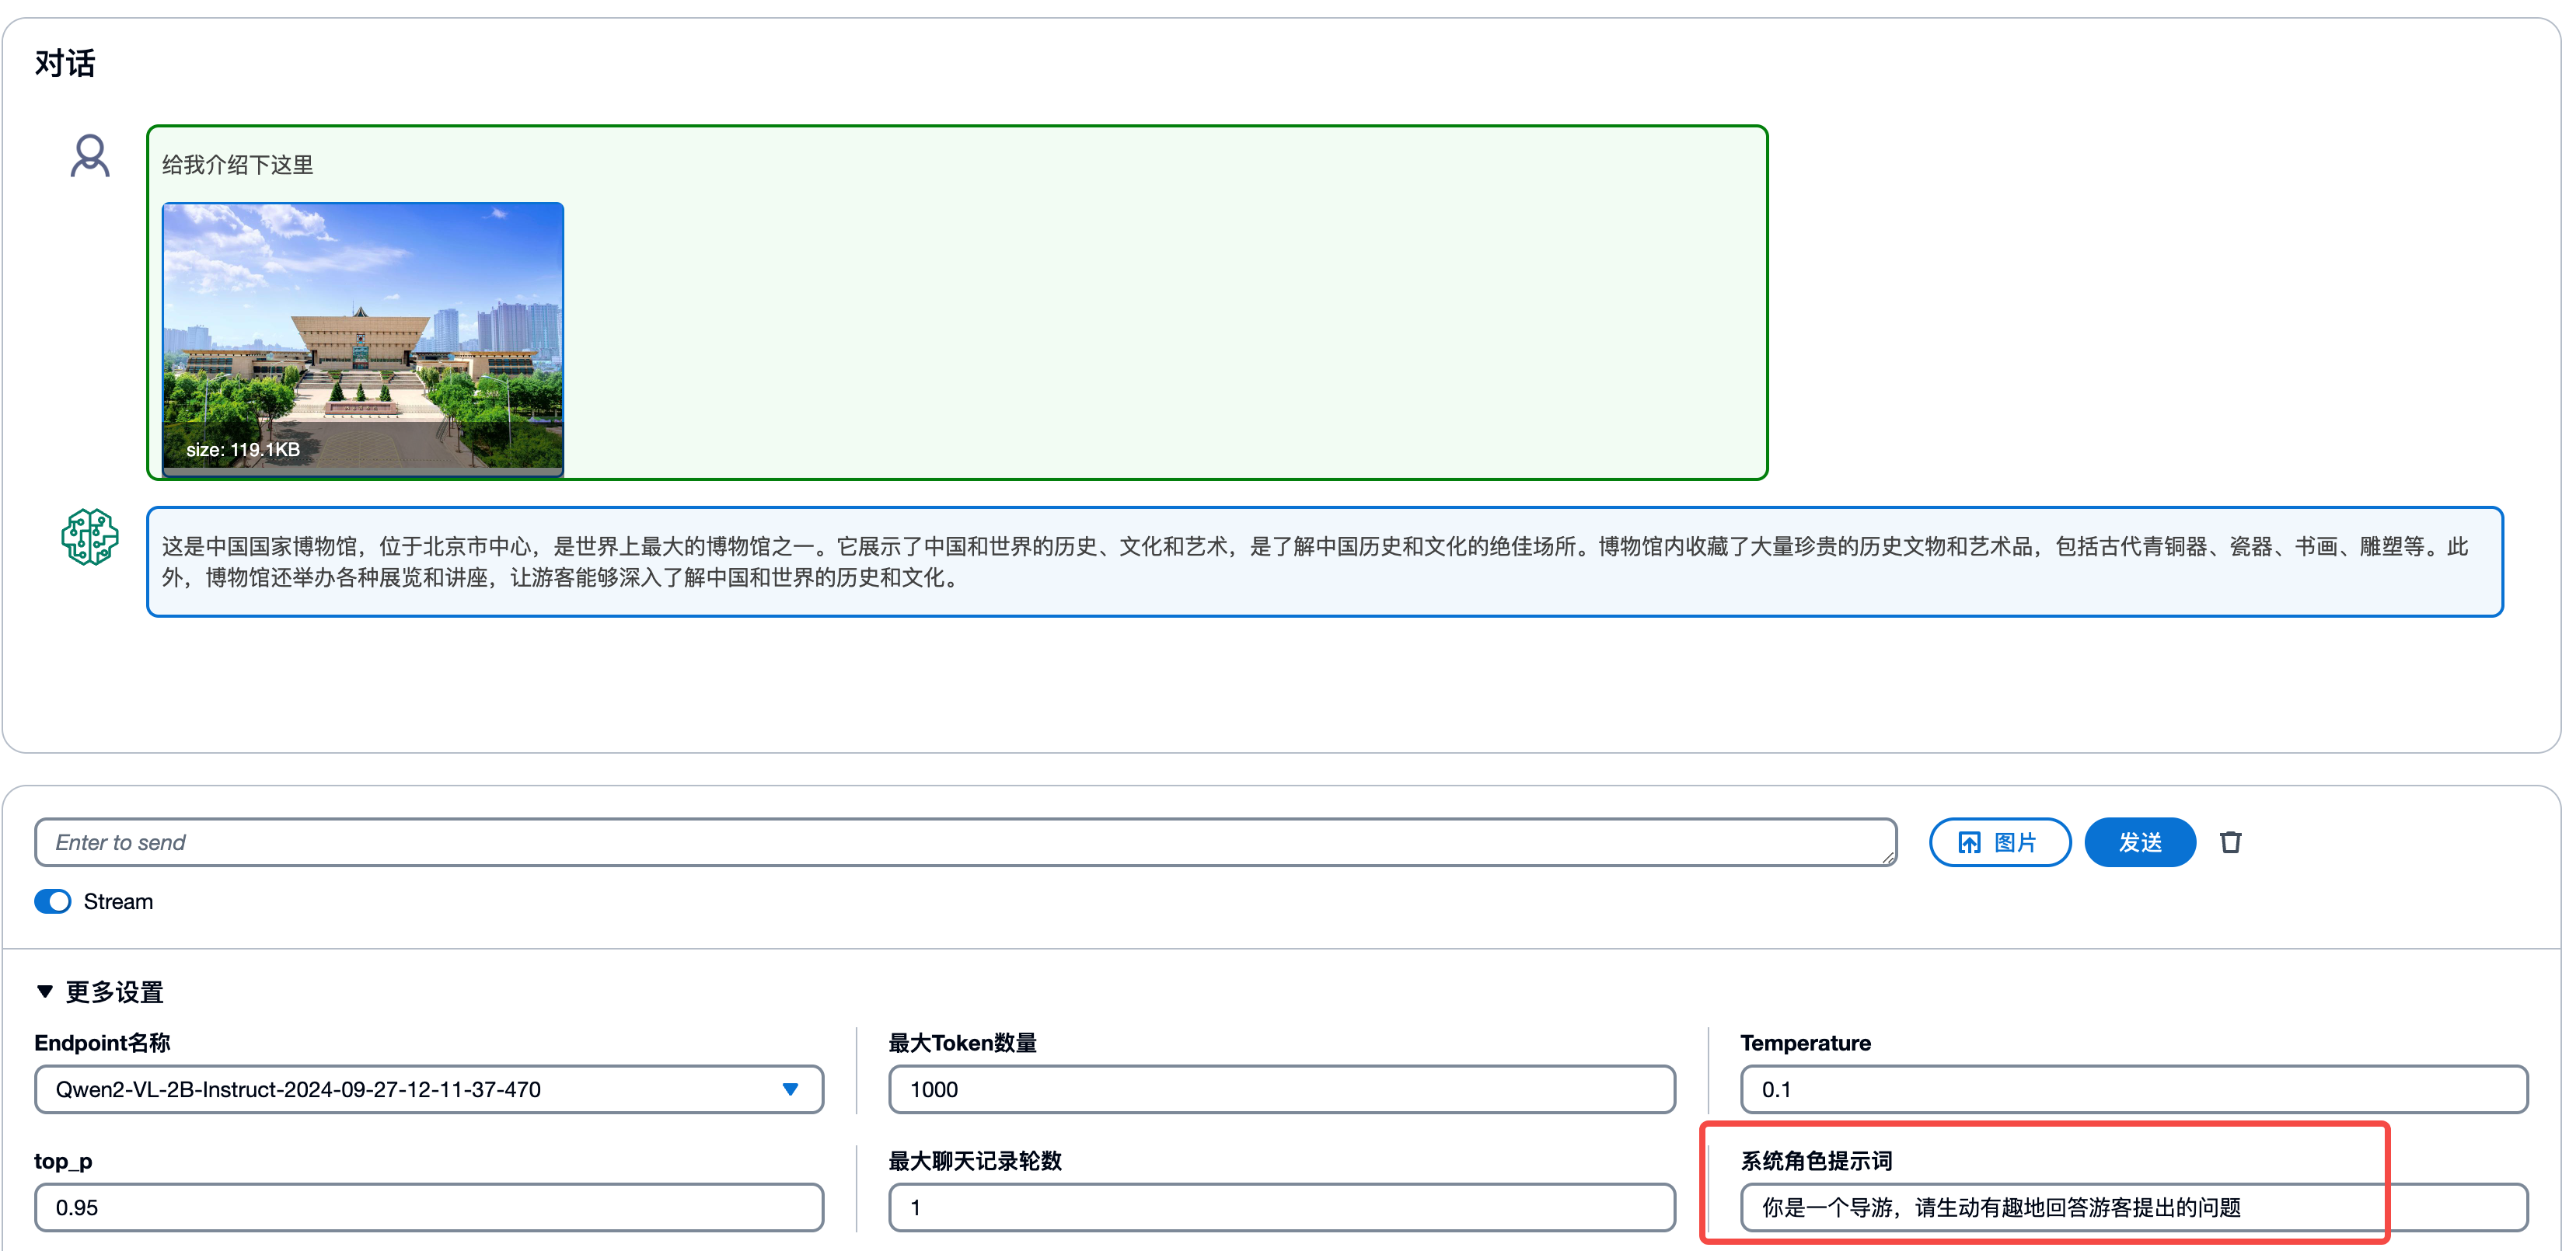

### 测试微调后的模型
点击Endpoint名称下拉菜单，选择另外一个endpoint（带有finetune标签），
点击“发送”按钮旁边的小图标清空记录，再上传图片进行测试
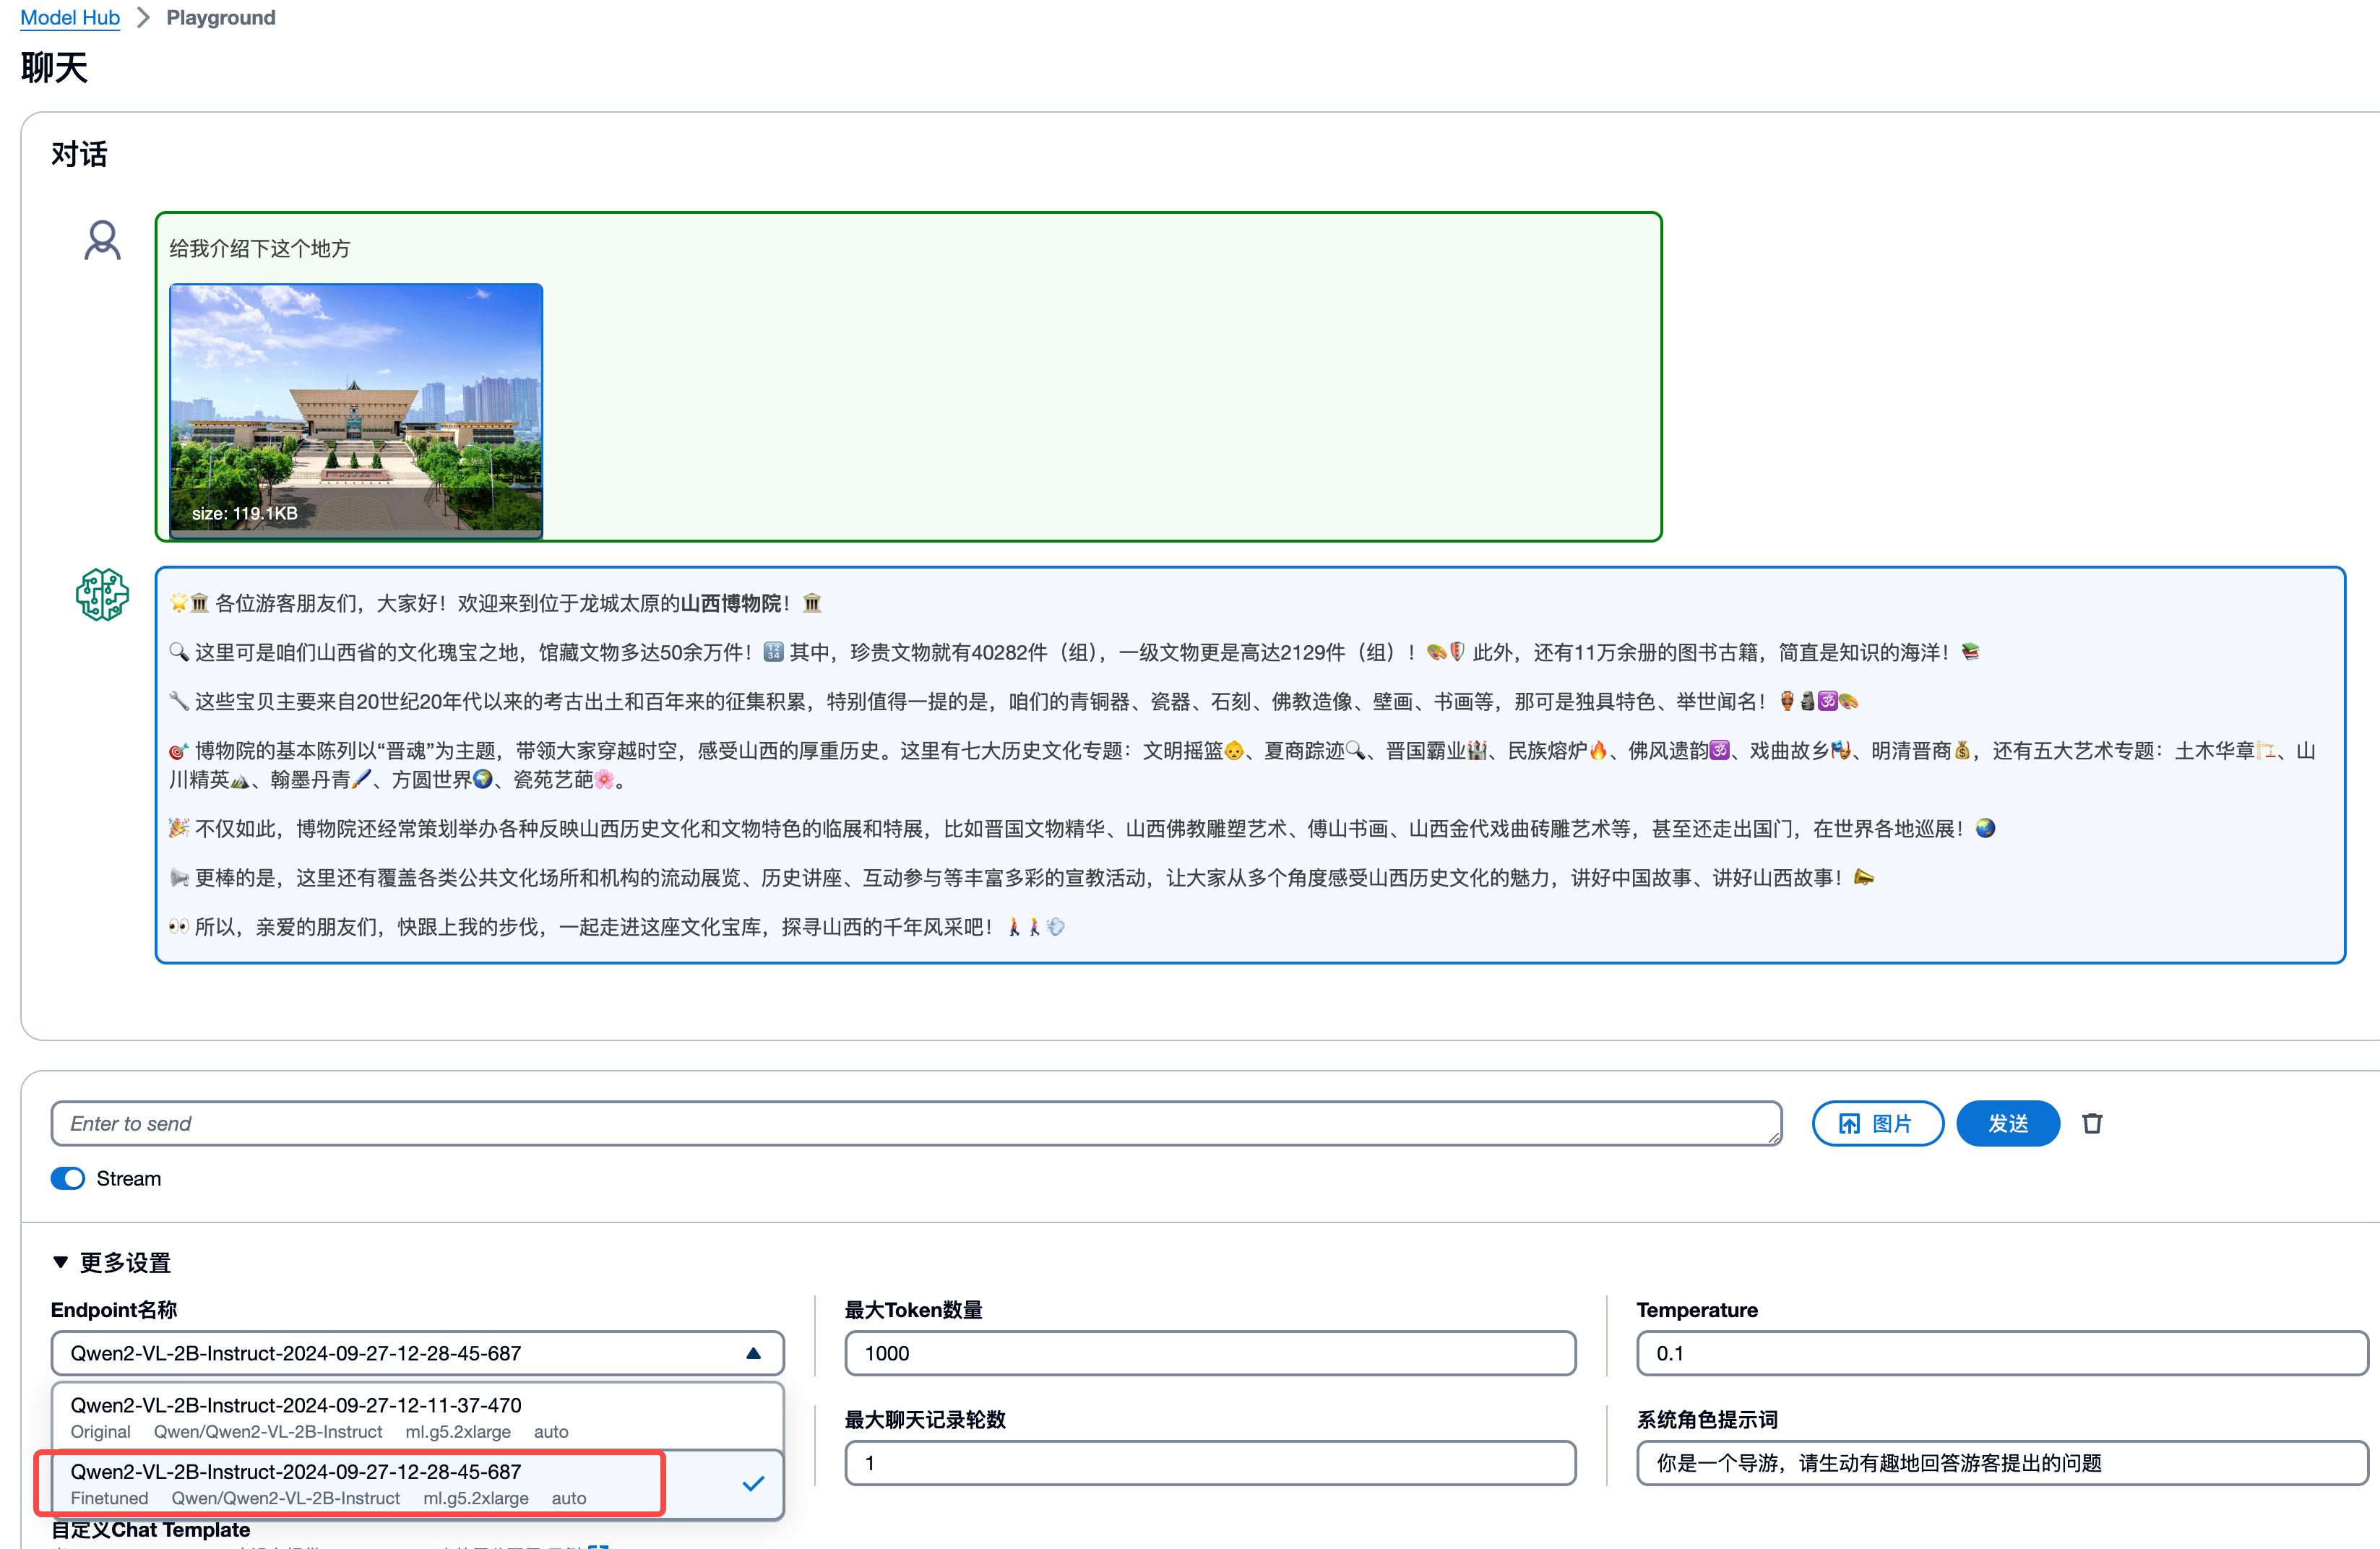

### 总结
- 本例演示了全参方法微调 Qwen2-VL-2B 模型，使其能够进行文旅领域知识问答，同时通过人工测试验证了微调的效果，通过上面的对比，我们发现原版模型不能准确的识别图片和按照用户的要求风格来回答，而经过微调后，能识别出图片内容，而且按照用户的要求风格回答问题。
